# Initialization

Import packages and setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif, r_regression, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin\Rscript'
from cdt.causality.graph import GES

import warnings
warnings.filterwarnings('ignore')

# Set the random seed for reproducibility
seed = 0
np.random.seed(seed)

C:\Users\prata\miniconda3\envs\default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Load dataset

In [2]:
def load_data(url):
    df = pd.read_csv(url, index_col=0)
    X = df.loc[:, df.columns != 'Churn Value']
    y = df.loc[:, df.columns == 'Churn Value']
    return df, X, y

df_train, X_train, y_train = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/train_data.csv')
df_val, X_val, y_val = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/val_data.csv')
df_test, X_test, y_test = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/test_data.csv')

# Causal Discovery

Define features and outcomes

In [3]:
features = X_train.columns.tolist()
outcomes = y_train.columns.tolist()

Discover causal structures

In [4]:
model = GES()
skeleton = nx.Graph(df_train.cov())
model_graph = model.predict(df_train, skeleton)

Detect relevant nodes and edges

In [5]:
relevant_features = set()
relevant_nodes = set()
relevant_edges = set()

for feature in features:
    for outcome in outcomes:
        if model_graph.has_edge(feature, outcome):
            relevant_features.add(feature)
            relevant_nodes.add(feature)
            relevant_nodes.add(outcome)
            relevant_edges.add((feature, outcome))

print(f'# of relevant features: {len(relevant_features)}\n')
for feature in sorted(relevant_features):
    print(feature)

# of relevant features: 6

Contract_Month-to-month
Dependents_Yes
Streaming Movies_No internet service
Streaming Movies_Yes
Tech Support_Yes
Tenure Months


Draw the causal graph

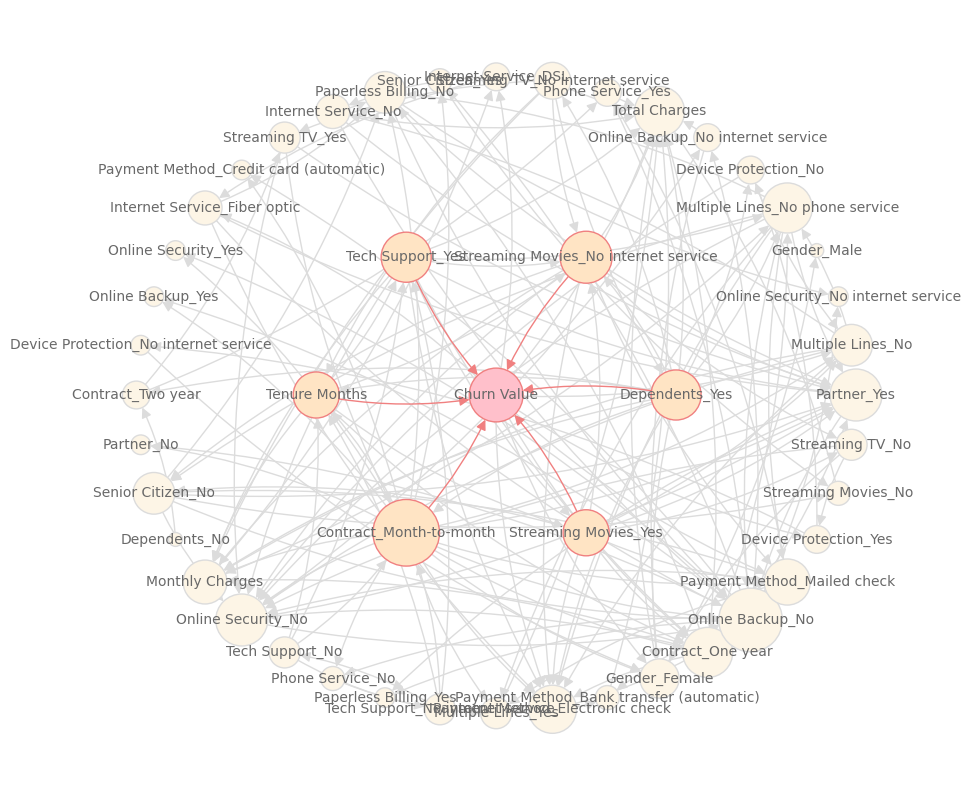

In [6]:
fig = plt.figure(figsize=(10, 8))
for i in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[i].set_visible(False)
    
# model_graph.remove_nodes_from(list(set(features) - (set(outcomes) | set(relevant_features))))

degrees = model_graph.degree()
node_colors = ['pink' if node in outcomes else 'bisque' if node in relevant_features else 'oldlace' for node in model_graph.nodes]
node_sizes = [max(v, 1) * 100 for k, v in degrees]
node_edge_colors = ['lightcoral' if node in relevant_nodes else 'gainsboro' for node in model_graph.nodes]
edge_colors = ['lightcoral' if edge in relevant_edges else 'gainsboro' for edge in model_graph.edges]
pos = nx.shell_layout(model_graph, [outcomes, relevant_features, list(set(features) - set(relevant_features))])

# draw the graph
nodes = nx.draw_networkx_nodes(model_graph,
                               pos=pos,
                               node_color=node_colors,
                               node_size=node_sizes,
                               edgecolors=node_edge_colors)

edges = nx.draw_networkx_edges(model_graph,
                               pos=pos,
                               connectionstyle="arc3,rad=0.1",
                               node_size=node_sizes,
                               edge_color=edge_colors,
                               arrowsize=15)

labels = nx.draw_networkx_labels(model_graph,
                                 pos,
                                 font_size=10,
                                 font_color='dimgray',
                                 clip_on=False)

# bring relevant edges to the top
edge_list = list(model_graph.edges)
edge_index = [edge_list.index(x) for x in relevant_edges]
for i, edge in enumerate(edges):
    if i in edge_index:
        edge.set_zorder(1)
    else:
        edge.set_zorder(0)

# plot the graph
plt.tight_layout()
plt.show()
# plt.savefig('graph.png', dpi=300)

# Evaluation

In [7]:
def evaluate(clf, x, y):
    y_pred = clf.predict(x)
    print(f'Overall accuracy: {accuracy_score(y, y_pred)}\n')
    print(classification_report(y, y_pred, zero_division=0))

In [8]:
def evaluateKNN(x_train, x_val, x_test):
    # hyperparameter tuning
    loss = []
    x_axis = np.linspace(5, 40, num=8, dtype=int)
    
    for i in x_axis:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_val)
        loss.append(log_loss(y_val, y_pred))

    # plot
    fig = plt.figure(figsize=(5, 3))
    plt.xticks(x_axis)
    plt.plot(x_axis, loss)
    plt.show()
    
    # find optimal neighbors
    sorted_loss = np.argsort(loss)
    n_neighbors = x_axis[sorted_loss[0]]
    print(f'\nOptimal neighbors: {n_neighbors}\n')

    # test
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    evaluate(knn, x_test, y_test)

In [9]:
def evaluateLR(x_train, x_val, x_test):
    # hyperparameter tuning
    loss = []
    x_axis = np.logspace(-3, 0, num=10)
    
    for i in x_axis:
        lr = LogisticRegression(C=i, random_state=seed)
        lr.fit(x_train, y_train)
        y_pred = lr.predict(x_val)
        loss.append(log_loss(y_val, y_pred))

    # plot
    fig = plt.figure(figsize=(5, 3))
    plt.xticks(x_axis)
    plt.xscale('log') 
    plt.plot(x_axis, loss)
    plt.show()
    
    # find optimal neighbors
    sorted_loss = np.argsort(loss)
    C = x_axis[sorted_loss[0]]
    print(f'\nOptimal C: {C}\n')

    # test
    lr = LogisticRegression(C=C, random_state=seed)
    lr.fit(x_train, y_train)
    evaluate(lr, x_test, y_test)

## All Features

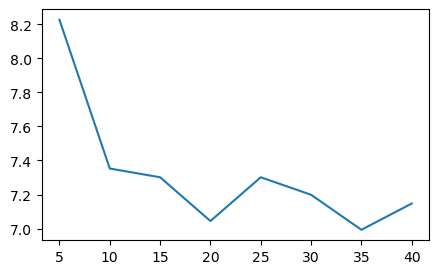


Optimal neighbors: 35

Overall accuracy: 0.8062678062678063

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       534
           1       0.58      0.66      0.62       168

    accuracy                           0.81       702
   macro avg       0.74      0.76      0.75       702
weighted avg       0.82      0.81      0.81       702



In [10]:
evaluateKNN(X_train, X_val, X_test)

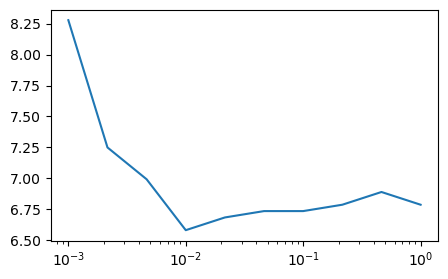


Optimal C: 0.01

Overall accuracy: 0.8176638176638177

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       534
           1       0.64      0.54      0.59       168

    accuracy                           0.82       702
   macro avg       0.75      0.72      0.74       702
weighted avg       0.81      0.82      0.81       702



In [11]:
evaluateLR(X_train, X_val, X_test)

## Causality Based Features

In [12]:
X_train_causal = X_train[list(relevant_features)]
X_val_causal = X_val[list(relevant_features)]
X_test_causal = X_test[list(relevant_features)]

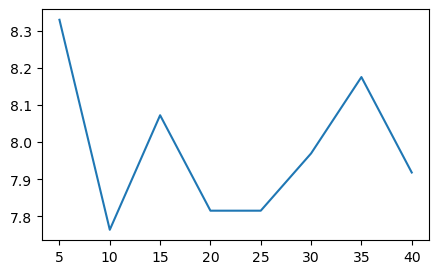


Optimal neighbors: 10

Overall accuracy: 0.8048433048433048

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       534
           1       0.61      0.51      0.56       168

    accuracy                           0.80       702
   macro avg       0.73      0.70      0.72       702
weighted avg       0.80      0.80      0.80       702



In [13]:
evaluateKNN(X_train_causal, X_val_causal, X_test_causal)

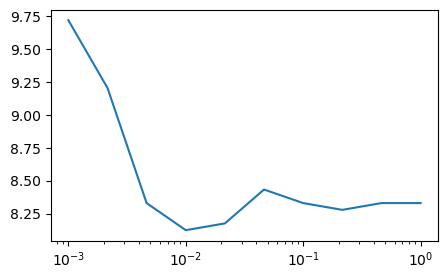


Optimal C: 0.01

Overall accuracy: 0.8034188034188035

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       534
           1       0.61      0.50      0.55       168

    accuracy                           0.80       702
   macro avg       0.73      0.70      0.71       702
weighted avg       0.79      0.80      0.80       702



In [14]:
evaluateLR(X_train_causal, X_val_causal, X_test_causal)

## ANOVA

In [15]:
anova = SelectKBest(f_classif, k=6).fit(X_train, y_train)

anova_features = X_train.iloc[:, np.argsort(anova.scores_)[:6]].columns.values

for feature in sorted(anova_features):
    print(feature)

Gender_Female
Gender_Male
Multiple Lines_No
Multiple Lines_No phone service
Phone Service_No
Phone Service_Yes


In [16]:
X_train_anova = anova.transform(X_train)
X_val_anova = anova.transform(X_val)
X_test_anova = anova.transform(X_test)

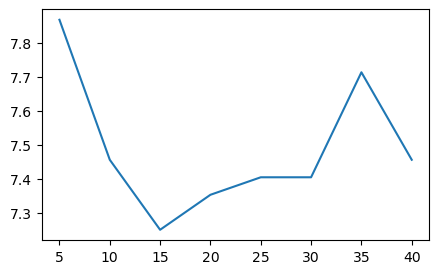


Optimal neighbors: 15

Overall accuracy: 0.7934472934472935

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       534
           1       0.58      0.48      0.53       168

    accuracy                           0.79       702
   macro avg       0.71      0.69      0.70       702
weighted avg       0.78      0.79      0.79       702



In [17]:
evaluateKNN(X_train_anova, X_val_anova, X_test_anova)

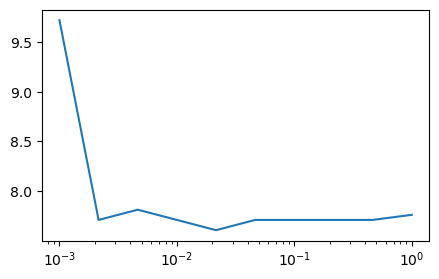


Optimal C: 0.021544346900318832

Overall accuracy: 0.7991452991452992

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       534
           1       0.61      0.45      0.52       168

    accuracy                           0.80       702
   macro avg       0.72      0.68      0.70       702
weighted avg       0.78      0.80      0.79       702



In [18]:
evaluateLR(X_train_anova, X_val_anova, X_test_anova)

## Pearson

In [19]:
pearson = SelectKBest(r_regression, k=6).fit(X_train, y_train)

pearson_features = X_train.iloc[:, np.argsort(pearson.scores_)[:6]].columns.values

for feature in sorted(pearson_features):
    print(feature)

Contract_Two year
Dependents_Yes
Device Protection_No internet service
Online Backup_No internet service
Tech Support_No internet service
Tenure Months


In [20]:
X_train_pearson = pearson.transform(X_train)
X_val_pearson = pearson.transform(X_val)
X_test_pearson = pearson.transform(X_test)

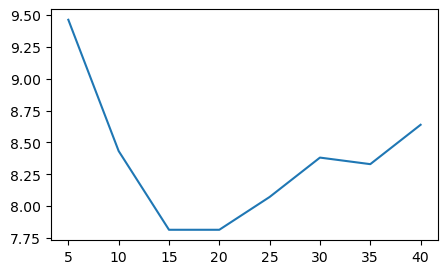


Optimal neighbors: 15

Overall accuracy: 0.7962962962962963

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       534
           1       0.58      0.56      0.57       168

    accuracy                           0.80       702
   macro avg       0.72      0.72      0.72       702
weighted avg       0.79      0.80      0.80       702



In [21]:
evaluateKNN(X_train_pearson, X_val_pearson, X_test_pearson)

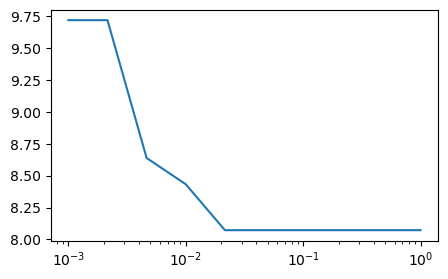


Optimal C: 0.021544346900318832

Overall accuracy: 0.7962962962962963

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       534
           1       0.59      0.51      0.54       168

    accuracy                           0.80       702
   macro avg       0.72      0.70      0.71       702
weighted avg       0.79      0.80      0.79       702



In [22]:
evaluateLR(X_train_pearson, X_val_pearson, X_test_pearson)

## PCA

In [23]:
pca = PCA(n_components=6).fit(X_train)

In [24]:
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

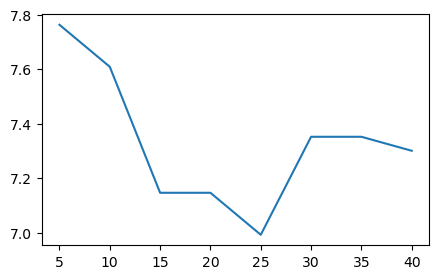


Optimal neighbors: 25

Overall accuracy: 0.8076923076923077

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       534
           1       0.61      0.54      0.57       168

    accuracy                           0.81       702
   macro avg       0.74      0.72      0.72       702
weighted avg       0.80      0.81      0.80       702



In [25]:
evaluateKNN(X_train_pca, X_val_pca, X_test_pca)

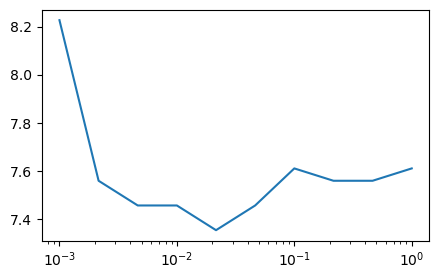


Optimal C: 0.021544346900318832

Overall accuracy: 0.8005698005698005

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       534
           1       0.60      0.50      0.55       168

    accuracy                           0.80       702
   macro avg       0.73      0.70      0.71       702
weighted avg       0.79      0.80      0.79       702



In [26]:
evaluateLR(X_train_pca, X_val_pca, X_test_pca)